In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')  

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pytz
from pytz import common_timezones, all_timezones
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
from datetime import datetime
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
matplotlib.style.use('fivethirtyeight')
matplotlib.style.use('seaborn-talk')

This ipython notebook will illustrate the matching methodology we will use to match patients in the SEER-Medicare linked database. The comparison between patient outcomes between those patients who receive proton beam therapy vs traditional radiation therapy requires as a first step a matching of the two different groups. One method to perform this matching is to use Propensity Score Matching. Here we are going to illustrate a more direct method of matching using KDTrees, a data structure that allows for efficient finding of nearest neighbors in high-dimenional space.

We will first identify all patients that have been diagonised with some type of head and neck cancer as defined by the following primary site codes: Nasopharynx: (C110, C111, C112, C113, C118, C119).
Then we will split the above patient population into two groups as follows: The treatment group, defined as the patients receiving any form of radiation the control group, defined as the patients who did not receive any form of radiation Operationally, these groups are defined by looking at the column RADIATN, which has values:


| Code	| Description |
|:---------:|:-------------:|
|0	|None; diagnosed at autopsy|
|1	|Beam radiation |
| 2 |	Radioacative implants |
|3	|Radioisotopes|
|4	|Combination of 1 with 2 or 3 |
|5	|Radiation, NOS - method or source not specified |
|6	|Other radiation (1973-1987 cases only)|
|7	|Patient or patient's guardian refused radiation therapy |
|8	|Radiation recommended, unknown if administered |
|9	|Unknown if radiation administered |

So that a value of 0 defines the control group, and the values (1,2,3,4,5,6) define the treatment group. We will then perform matching between the resulting treatment and control groups.

In [3]:
import seerhelp
otherfiles = seerhelp.get_otherfiles()
otherfiles

dfother0 = seerhelp.make_clean_dataframe(otherfiles[0])
dfother1 = seerhelp.make_clean_dataframe(otherfiles[1])
dfother2 = seerhelp.make_clean_dataframe(otherfiles[2])
dfother3 = seerhelp.make_clean_dataframe(otherfiles[3])

dfother = pd.concat([dfother0, dfother1, dfother2,
                     dfother3], ignore_index=True)

#dfother = pd.concat([dfother0, dfother1,dfother3], ignore_index=True)

print(dfother.shape)

del dfother0
del dfother1
del dfother2
del dfother3

(1581838, 141)


In [5]:
dfother.PRIMSITE.value_counts()

Unknown primary site                                                     170561
Thyroid gland                                                            167854
Skin of trunk                                                            164671
Skin of upper limb and shoulder                                          131779
Skin of lower limb and hip                                                94148
Skin of other and unspecified parts of face                               84382
Bone marrow                                                               82123
Cerebral meninges                                                         58481
Skin of scalp and neck                                                    44256
Pituitary gland                                                           32340
Frontal lobe                                                              27753
Skin, NOS                                                                 26011
Base of tongue, NOS                     

In [6]:
dfnasoorig = dfother[dfother.PRIMSITE.str.contains('nasopharynx',case=False,na=False)]

dfnasoorig.PRIMSITE.value_counts()


Nasopharynx, NOS                     8670
Posterior wall of nasopharynx        1230
Lateral wall of nasopharynx          1049
Overlapping lesion of nasopharynx     604
Superior wall of nasopharynx          212
Anterior wall of nasopharynx          198
Name: PRIMSITE, dtype: int64

In [7]:
mask = (dfnasoorig['CSTUMSIZ'] != "Unknown; size not stated; not stated in patient record") & \
(dfnasoorig['CSTUMSIZ'] != "Microscopic focus or foci only; no size of focus is given") & \
(dfnasoorig['CSTUMSIZ'] != "989 millimeters or larger") & \
(dfnasoorig['CSTUMSIZ'] != "Not applicable") & \
(dfnasoorig['AGE_DX'] != "Unknown age") & \
(dfnasoorig['srv_time_mon_flag'] == "Complete dates are available and there are more than 0 days of survival") & \
(dfnasoorig['YEAR_DX'] >= 2004) & \
(dfnasoorig['CSTUMSIZ'] != "Described as less than 1 cm") & \
(dfnasoorig['CSTUMSIZ'] != "Described as less than 2 cm") & \
(dfnasoorig['CSTUMSIZ'] != "Described as less than 3 cm") & \
(dfnasoorig['CSTUMSIZ'] != 'Indicates no msas or no tumor found; for example, when a tumor of a stated primary site is not found, but the tumor has metastasized') & \
(dfnasoorig['CSTUMSIZ'] != "Described as less than 4 cm") & \
(dfnasoorig['CSTUMSIZ'] != "Described as less than 5 cm") & \
(dfnasoorig['CSTUMSIZ'] != "Not applicable") & \
(dfnasoorig['YR_BRTH'] != 'Unknown year of birth') & \
(dfnasoorig['CSTUMSIZ'] != 'Not applicable') & \
(dfnasoorig['CSTUMSIZ'] != 996) & \
(dfnasoorig['CSTUMSIZ'] != 997) & \
(dfnasoorig['CSTUMSIZ'] != 998) & \
(dfnasoorig['REC_NO'] == 1) 

dfnaso = dfnasoorig[mask]



In [8]:
non_rad = dfnaso.RADIATN.str.contains('None',case=False,na=False)
refused_rad = dfnaso.RADIATN.str.contains('refused',case=False,na=False)
unknown_rad = dfnaso.RADIATN.str.contains('Unknown',case=False,na=False)

In [9]:
dfnasocontrol = dfnaso[non_rad | refused_rad].copy()
dfnasotreatment = dfnaso[~(non_rad) & ~(refused_rad) & ~(unknown_rad)].copy()

## <font color='steelblue'>Only 317 Nasopharynx cancer patients did **not** receive radiation</font>

In [11]:
print(dfnasocontrol.shape, dfnasotreatment.shape)

(317, 141) (2133, 141)


## <font color='steelblue'>So we are going to match patients in the control group with their nearest neighbors in the treatment group</font>

In order to find the nearest neighbors in the high-dimensional feature space, we need to first do some preprocessing of the data. The first step is to "one-hot-encode" the categorical features.

In [12]:
dfnasocontrol.set_index('PUBCSNUM', inplace=True)
dfnasotreatment.set_index('PUBCSNUM', inplace=True)

controlindices = dfnasocontrol.index
treatmentindices = dfnasotreatment.index

catcols = ['SEX','MAR_STAT','RACEIV','NHIADE','GRADE','PRIMSITE',
          'LATERAL','HST_STGA','HISTREC','MDXRECMP','STAT_REC']

goodcols = ['SEX','MAR_STAT','RACEIV','NHIADE','GRADE','PRIMSITE',
          'LATERAL','HST_STGA','HISTREC','MDXRECMP','STAT_REC',
           'YR_BRTH','AGE_DX','YEAR_DX','CSTUMSIZ',
           'lat','lng']


dfpop = pd.concat([dfnasocontrol, dfnasotreatment],verify_integrity=True)

## <font color='steelblue'>Before matching, let's look at the Kaplan-Meier curves

In [13]:
resgoodcontrol = pd.concat([pd.get_dummies(dfnasocontrol[col],prefix=col) for col in catcols], axis=1)

resgoodtreatment = pd.concat([pd.get_dummies(dfnasotreatment[col],prefix=col) for col in catcols], axis=1)

resgoodpop = pd.concat([pd.get_dummies(dfpop[col],prefix=col) for col in catcols], axis=1)

resgoodcontrol['YR_BRTH'] = dfnasocontrol['YR_BRTH']
resgoodcontrol['AGE_DX'] = dfnasocontrol['AGE_DX']#resgood['sequence_number_central'] = dfsmall['sequence_number_central']
resgoodcontrol['YEAR_DX'] = dfnasocontrol['YEAR_DX']
resgoodcontrol['CSTUMSIZ'] = dfnasocontrol['CSTUMSIZ']
resgoodcontrol['lat'] = dfnasocontrol['lat']
resgoodcontrol['lng'] = dfnasocontrol['lng']
resgoodcontrol['srv_time_mon'] = dfnasocontrol['srv_time_mon']


resgoodtreatment['YR_BRTH'] = dfnasotreatment['YR_BRTH']
resgoodtreatment['AGE_DX'] = dfnasotreatment['AGE_DX']#resgood['sequence_number_central'] = dfsmall['sequence_number_central']
resgoodtreatment['YEAR_DX'] = dfnasotreatment['YEAR_DX']
resgoodtreatment['CSTUMSIZ'] = dfnasotreatment['CSTUMSIZ']
resgoodtreatment['lat'] = dfnasotreatment['lat']
resgoodtreatment['lng'] = dfnasotreatment['lng']
resgoodtreatment['srv_time_mon'] = dfnasotreatment['srv_time_mon']


resgoodpop['YR_BRTH'] = dfpop['YR_BRTH']
resgoodpop['AGE_DX'] = dfpop['AGE_DX']#resgood['sequence_number_central'] = dfsmall['sequence_number_central']
resgoodpop['YEAR_DX'] = dfpop['YEAR_DX']
resgoodpop['CSTUMSIZ'] = dfpop['CSTUMSIZ']
resgoodpop['lat'] = dfpop['lat']
resgoodpop['lng'] = dfpop['lng']
resgoodpop['srv_time_mon'] = dfpop['srv_time_mon']

## <font color='steelblue'>After performing the matching between the control and treatment groups, we can see how the Kaplan-Meier curves differ</font>

Below is how it looks **before** matching patients in the control and treatment groups together in pairs.

In [14]:
from lifelines import KaplanMeierFitter

kmfpop = KaplanMeierFitter()
kmfcontrol = KaplanMeierFitter()
kmftreatment = KaplanMeierFitter()

Tcontrol = resgoodpop.loc[controlindices]["srv_time_mon"]
Econtrol = resgoodpop.loc[controlindices]["STAT_REC_Dead"]

Ttreatment = resgoodpop.loc[treatmentindices]["srv_time_mon"]
Etreatment = resgoodpop.loc[treatmentindices]["STAT_REC_Dead"]

Tpop = resgoodpop["srv_time_mon"]
Epop = resgoodpop["STAT_REC_Dead"]

kmfpop.fit(Tpop, event_observed=Epop,label='All nasopharynx');
kmfcontrol.fit(Tcontrol, event_observed=Econtrol,label='No Radiation Group (control group)')
kmftreatment.fit(Ttreatment, event_observed=Etreatment, label='Radiation Group (treatment group)')
#ax = kmfpop.plot()
#ax = kmfcontrol.plot()
#kmftreatment.plot(ax=ax)
#plt.title("Left-sided breast cancer patients Kaplan-Meier Curve (95% CI) \n Pre-Matching");

<lifelines.KaplanMeierFitter: fitted with 2133 observations, 1508 censored>

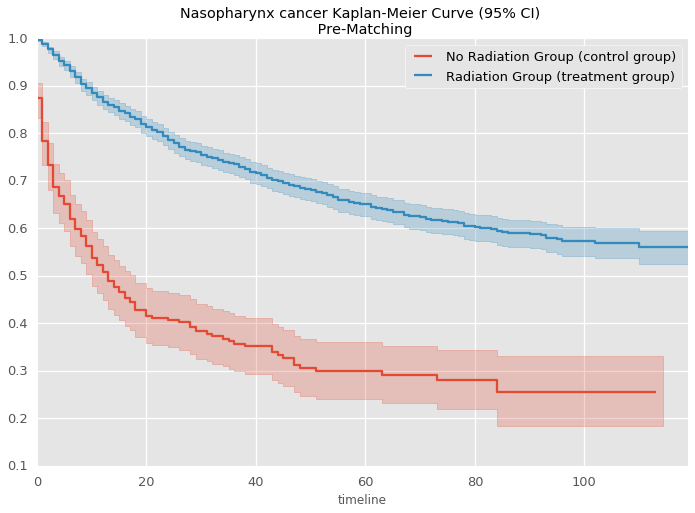

In [15]:
ax = kmfcontrol.plot()
kmftreatment.plot(ax=ax)
plt.title("Nasopharynx cancer Kaplan-Meier Curve (95% CI) \n Pre-Matching");

## <font color='steelblue'>Clearly, there is a huge benefit to receiving radiation</font>

However, one could logically argue that it is not radiation treatment that is leading to the better survival prognosis, but rather some other feature that leads to better prognosis is also leading to a greater likelihood of receiving radiation therapy. So that we are not really comparing apples to apples when we calculate these two survival curves. To answer this objection, we need to perform patient matching, so that we are really comparing apples to apples and that any marked difference in the survival curves can be confidently attributed to the posistive effects of radiation.

In [16]:
resgoodpop['YR_BRTH'] = resgoodpop['YR_BRTH'].astype('int')
resgoodpop['AGE_DX'] = resgoodpop['AGE_DX'].astype('int')
resgoodpop['CSTUMSIZ'] = resgoodpop['CSTUMSIZ'].astype('float')
resgoodpop['lat'] = resgoodpop['lat'].astype('float')
resgoodpop['lng'] = resgoodpop['lng'].astype('float')
resgoodpop['srv_time_mon'] = resgoodpop['srv_time_mon'].astype('float')

newcolumns = list(resgoodpop.columns)


newcolumns.remove('srv_time_mon')
newcolumns.remove('STAT_REC_Alive')
newcolumns.remove('STAT_REC_Dead')
newcolumns.remove('SEX_Female')

resgreatpop = resgoodpop[newcolumns].copy()

In [17]:
resgreatpop['PUBCSNUM'] = resgreatpop.index
leaguefilter = (resgreatpop['PUBCSNUM'].loc[treatmentindices])
resgreatpop['League'] = resgreatpop['PUBCSNUM'].isin(treatmentindices).astype('int')
del resgreatpop['PUBCSNUM']
dftree = resgreatpop.copy()

y = dftree['League'].copy()
del dftree['League']

In [18]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.multiclass import OneVsRestClassifier

import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plot
#import psycopg2
import random
from sklearn import ensemble
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.cross_validation import StratifiedShuffleSplit
import pylab as plot
from pandas import DataFrame, Series
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn import feature_extraction
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import ParameterGrid
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
#from sklearn.neural_network import MultilayerPerceptronClassifier
from sklearn.neural_network import BernoulliRBM
from sklearn.svm import SVC
import pylab as pl
from sklearn.decomposition import RandomizedPCA
from itertools import cycle
from sklearn.cross_validation import ShuffleSplit
from scipy.stats import sem
from pprint import pprint
from math import sqrt, fabs, exp
import matplotlib.pyplot as plot
from sklearn.cross_validation import train_test_split
from sklearn import ensemble
from sklearn.metrics import roc_auc_score, roc_curve
import numpy
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from pandas.tools.plotting import lag_plot

This direct force method of finding similar patients characterized by points in a high-dimensional space is possible for this data set as well as for Big Data sized data sets thanks to a data structure called a KDTree. In order to construct the KDTree, we first need to transform the numeric data so that all of the different features contribute equally to the euclidean distance between patients/records. For example, **AGE_DX** is on the order of 60 or so, while **YR_BRTH** is around 1960. Without standardization, **YR_BRTH** would contribute much more to the distance between patients than **AGE_DX**. The result of standardization (or z-score normalization) is that features will be rescaled so that they will have the properties of a standard normal distribution with

$\mu = 0$ and $\sigma = 1$

where $\mu$ is the mean (average) and $\sigma$ is the standard deviation from the mean; standard deviation scores (also called z-scores) are then calculated as follows:

$
z_{i} = \frac{x_{i} - \mu}{\sigma}
$

In [19]:
xTrain = dftree.values
xTrain = StandardScaler().fit_transform(xTrain)
from sklearn.neighbors import KDTree
print(xTrain)

[[ 0.66357307 -0.30057059  0.87326395 ...,  0.13370121  1.009353
   1.70358659]
 [-1.50699304 -0.30057059 -1.14512914 ..., -0.22015854  0.99492038
   1.67584176]
 [-1.50699304 -0.30057059 -1.14512914 ..., -0.39708841  1.10439477
   1.70358659]
 ..., 
 [ 0.66357307 -0.30057059  0.87326395 ..., -0.30862348 -1.26335224
   0.76227089]
 [ 0.66357307 -0.30057059  0.87326395 ..., -0.5563253  -1.26335224
   0.76227089]
 [ 0.66357307 -0.30057059  0.87326395 ..., -0.1316936  -1.07102393
   0.7059259 ]]


In [20]:
from sklearn.neighbors import KDTree
kdt = KDTree(xTrain, leaf_size=30)

## <font color='steelblue'>Here is a video explaining the construction of a KDTree</font>

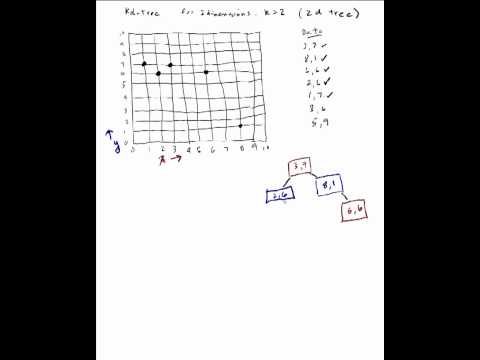

In [21]:
from IPython.display import YouTubeVideo
YouTubeVideo('LdaL-l2S76c')

In [69]:
dftreeleague = dftree.copy()
dftreeleague['League'] = y

def get_league(x):
    return dftreeleague['League'].loc[x]

dist4, ind4 = kdt.query(xTrain, k=4, return_distance=True)

## <font color='steelblue'>Finding the distances to all of the 4 nearest neighbors took about one second</font>

In [70]:
dftreeleague['nearest'] = pd.Series(ind4[:,0],index=dftreeleague.index)
dftreeleague['neighbor_1'] = pd.Series(ind4[:,1],index=dftreeleague.index)
dftreeleague['neighbor_2'] = pd.Series(ind4[:,2],index=dftreeleague.index)
dftreeleague['neighbor_3'] = pd.Series(ind4[:,3],index=dftreeleague.index)
dftreeleague['distance_1'] = pd.Series(dist4[:,1],index=dftreeleague.index)
dftreeleague['distance_2'] = pd.Series(dist4[:,2],index=dftreeleague.index)
dftreeleague['distance_3'] = pd.Series(dist4[:,3],index=dftreeleague.index)

dfmap = {v: dftreeleague.index[v] for v in range(dftreeleague.shape[0])}

In [71]:
def get_pubcsnum(x,transformationdict = dfmap):
    return dfmap[x]


dftreeleague['neighbor_1'] = dftreeleague['neighbor_1'].apply(get_pubcsnum)
dftreeleague['neighbor_2'] = dftreeleague['neighbor_2'].apply(get_pubcsnum)
dftreeleague['neighbor_3'] = dftreeleague['neighbor_3'].apply(get_pubcsnum)

def get_league(x):
    return dftreeleague['League'].loc[x]

dftreeleague['neighbor_1_League'] = dftreeleague['neighbor_1'].apply(get_league)
dftreeleague['neighbor_2_League'] = dftreeleague['neighbor_2'].apply(get_league)
dftreeleague['neighbor_3_League'] = dftreeleague['neighbor_3'].apply(get_league)

neighbor_1_match = (dftreeleague['neighbor_1_League'] == 0)

dist1filter = (dftreeleague['distance_1'] <=  3)
dist2filter = (dftreeleague['distance_2'] <= 3)
dist3filter = (dftreeleague['distance_3'] <= 8)

one = dftreeleague[['neighbor_1','distance_1',
                  'neighbor_1_League'
]][(dftreeleague['neighbor_1_League'] != dftreeleague['League']) & (neighbor_1_match) & (dist1filter)].copy()


neighbor_2_match = (dftreeleague['neighbor_2_League'] == 0)

two = dftreeleague[['neighbor_2','distance_2',
                  'neighbor_2_League'
]][(dftreeleague['neighbor_2_League'] != dftreeleague['League']) & (neighbor_2_match) & (dist2filter)].copy()


neighbor_3_match = (dftreeleague['neighbor_3_League'] == 0)

three = dftreeleague[['neighbor_3','distance_3',
                  'neighbor_3_League'
]][(dftreeleague['neighbor_3_League'] != dftreeleague['League']) & (neighbor_3_match) & (dist3filter) ].copy()

one.head(10)

,neighbor_1,distance_1,neighbor_1_League
PUBCSNUM,,,
11826145,41795937,2.281708,0
11868950,95774412,1.868152,0
18758076,80206700,2.843321,0
18788712,94522658,2.941392,0
18885487,27980255,2.003769,0
20043618,95781171,2.544515,0
27845202,94522658,1.213309,0
27858484,76049225,1.421872,0
27914409,99354197,1.884781,0


In [72]:
onedict = one['neighbor_1'].to_dict()
twodict = two['neighbor_2'].to_dict()
threedict = three['neighbor_3'].to_dict()

from collections import defaultdict

dd = defaultdict(list)

for d in (onedict, twodict):
    for key, value in d.items():
        dd[key].append(value)
        
        

goodtreatmentteams = list(dd.keys())

goodcontrolteams = list(dd.values())
matches = list(set([item for sublist in goodcontrolteams for item in sublist]))

controlindices = matches
treatmentindices = goodtreatmentteams
print(len(treatmentindices))
print(len(controlindices))

80
60


## <font color='steelblue'>Need to do a one-to-one matching (where each member of the treatment group is matched to one and only one member of the control group, and vice-versa)</font>

In [73]:
d_one_to_one = {k: dd[k][0] for k in dd}
d_t_c = {}

for key, value in d_one_to_one.items():
    if value not in d_t_c.values():
        d_t_c[key] = value
        
treatmentindices = list(d_t_c.keys())
controlindices = list(d_t_c.values())     

In [74]:
treatmentindices = list(d_t_c.keys())
controlindices = list(d_t_c.values())

print(len(controlindices), len(treatmentindices))

58 58


So we only have 58 treatment patients matched within a distance of 3 standaradized distance units in the high dimensional space to 58 control patients. This is a result of the very few number of nasopharynx that do not receive radiation. The numbers will be different for our real problem.

## <font color='steelblue'>Now here is the Kaplan-Meier plot for the post-matching treatment and control groups</font>

In [75]:
from lifelines import KaplanMeierFitter

#kmfpop = KaplanMeierFitter()
kmfcontrolpost = KaplanMeierFitter()
kmftreatmentpost = KaplanMeierFitter()

Tcontrol = resgoodpop.loc[controlindices]["srv_time_mon"]
Econtrol = resgoodpop.loc[controlindices]["STAT_REC_Dead"]

Ttreatment = resgoodpop.loc[treatmentindices]["srv_time_mon"]
Etreatment = resgoodpop.loc[treatmentindices]["STAT_REC_Dead"]

Tpop = resgoodpop["srv_time_mon"]
Epop = resgoodpop["STAT_REC_Dead"]

#kmfpop.fit(Tpop, event_observed=Epop,label='All Nasopharynx');
kmfcontrolpost.fit(Tcontrol, event_observed=Econtrol,label='No Radiation Group (control group; post-matching)')
kmftreatmentpost.fit(Ttreatment, event_observed=Etreatment, label='Radiation Group (treatment group; post-matching)')
#ax = kmfpop.plot()
###ax = kmfcontrol.plot()
###kmftreatment.plot(ax=ax)
###plt.title("Nasopharynx Kaplan-Meier Curve (95% CI) \n Post-Matching");

<lifelines.KaplanMeierFitter: fitted with 58 observations, 35 censored>

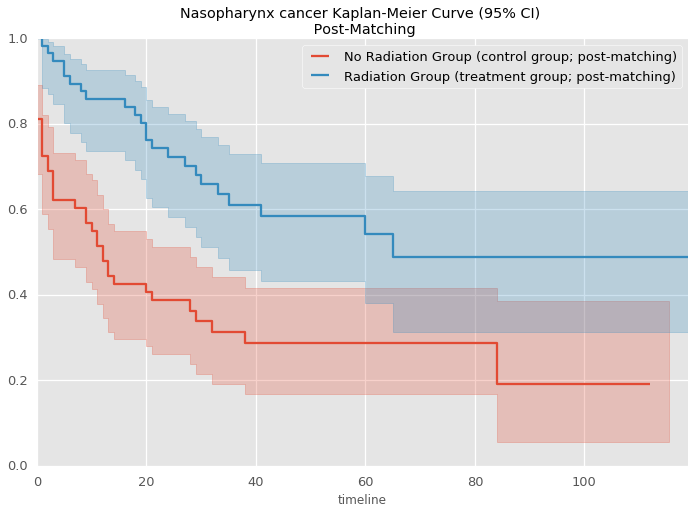

In [76]:
ax = kmfcontrolpost.plot()
kmftreatmentpost.plot(ax=ax)
#kmfcontrol.plot(ax=ax)
#kmftreatment.plot(ax=ax)
plt.title("Nasopharynx cancer Kaplan-Meier Curve (95% CI) \n Post-Matching");

## <font color='steelblue'>We can perform a rigorous test to see if the two survival curves abpve truly have different "death generation processes."</font>

No need to; its viisually obvious.

In [77]:
from lifelines.statistics import logrank_test
results = logrank_test(Ttreatment, Tcontrol, Etreatment, Econtrol)
results.print_summary()

Results
   df: 1
   null distribution: chi squared
   test: logrank
   alpha: 0.95
   t 0: -1

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.00011 |             14.962 |      Reject Null    |        True       


## <font color='steelblue'>Becuase of the matching, the observed differences in the Kaplan-Meier estimates of the survival curves for the control and treatment groups clearly show that there is a statistically significant benefit to opting for radiation for nasopharynx cancer patients.</font>

### <font color='steelblue'>Now let's perform some paired t-tests to see if there is any demonstrable difference for some characteristics of interst.</font>

You may suspect that some of the observed differences above are due to differences in the age distributions of the traetment and control groups (but our matching procedure should have taken care of and accounted for this possibility; let's see if a t-test based on **AGE_DX** can show that this is not the case).

In [78]:
control_age_dx = resgoodpop['AGE_DX'].loc[controlindices]
treatment_age_dx = resgoodpop['AGE_DX'].loc[treatmentindices]
dfage_comp = pd.DataFrame({'control_id': control_age_dx.index,
                          'control_age_dx': control_age_dx.values,
                          'treatment_id': treatment_age_dx.index,
                          'treatment_age_dx':treatment_age_dx.values })
dfage_comp['c_minus_t_age'] = dfage_comp.control_age_dx - dfage_comp.treatment_age_dx

## <font color='steelblue'>Two-sample T-test</font>

A two-sample t-test investigates whether the means of two independent data samples differ from one another. In a two-sample test, the null hypothesis is that the means of the corresponding populations are the same.

In [79]:
import scipy.stats as stats
stats.ttest_ind(a=dfage_comp.control_age_dx.as_matrix(), 
               b=dfage_comp.treatment_age_dx.as_matrix(),
               equal_var=False)   # assume samples have equal variance?

Ttest_indResult(statistic=0.98033623585270691, pvalue=0.32900235264926647)

The test yields a p-value of 0.329, which means that there is a 32.9% chance we'd see sample data this far apart if the two groups actually have idential AGE_DX distributions. P-values between 0 and .10 are borderline.

## <font color='steelblue'>Paired T-Test</font>

The basic two sample t-test is designed for testing differences between independent groups. In some cases, you might be interested in testing differences between samples of the same group at different points in time. In observational studies like those using the SEER data, the matched pairs in the control and treatment groups are considered for the purposes of paired t-tests to represent the same entity. Let's see now if there is any significant difference in **AGE_DX** between the treatment and control groups using a paired t-test.

In [80]:
stats.ttest_rel(a = dfage_comp.control_age_dx.as_matrix(),
                b = dfage_comp.treatment_age_dx.as_matrix())

Ttest_relResult(statistic=1.7690249083744751, pvalue=0.08223966347199517)

The paired T-test also indicates that we actually do not have enough evidence to reject the null hypothesis.

In [81]:
apost = dftreeleague['AGE_DX'][treatmentindices]
bpost = dftreeleague['AGE_DX'][controlindices]

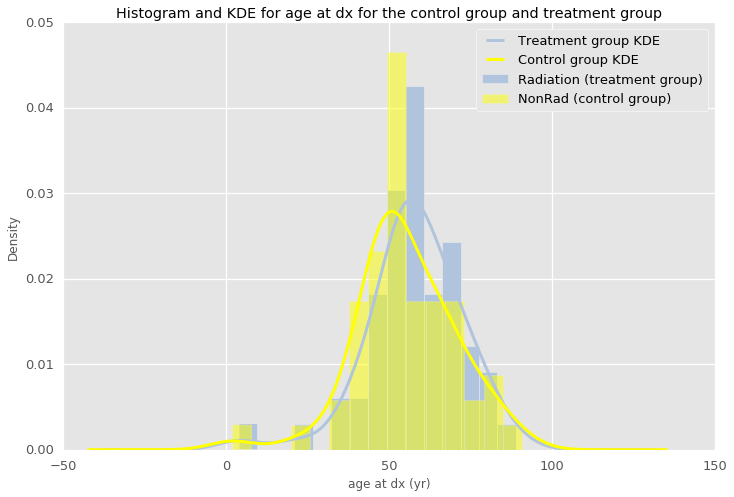

In [85]:
ax = bpost.hist(bins=15,color='LightSteelBlue',normed=True,label='Radiation (treatment group)')
bpost.plot(kind='kde',lw=3, color='LightSteelBlue', ax=ax, label='Treatment group KDE')
apost.hist(bins=15,color='yellow',normed=True,alpha=.5,label='NonRad (control group)')
apost.plot(kind='kde',lw=3, color='yellow', ax=ax, label='Control group KDE')
plt.title('Histogram and KDE for age at dx for the control group and treatment group')
plt.xlabel('age at dx (yr)')
plt.legend();

In [86]:
dfage_comp[['control_age_dx','treatment_age_dx']].describe()



,control_age_dx,treatment_age_dx
count,58.000000,58.000000
mean,57.896552,55.172414
std,14.546585,15.370441
min,4.000000,2.000000
25%,50.250000,46.250000
50%,57.000000,53.000000
75%,67.000000,64.000000
max,89.000000,91.000000


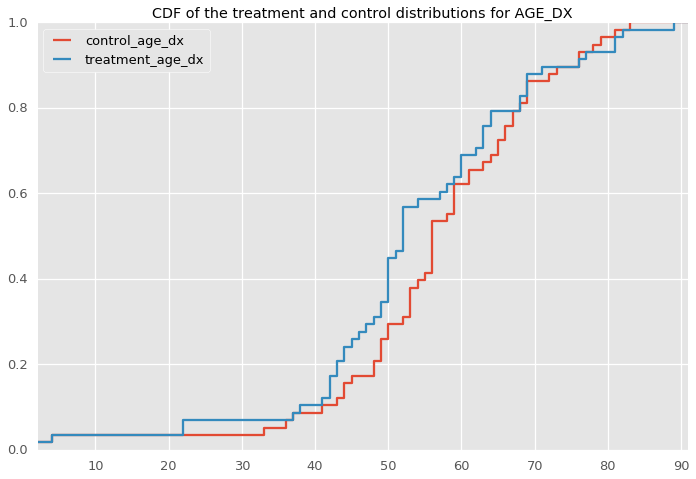

In [87]:
agedxtreatmentcdf = dfage_comp.treatment_age_dx.value_counts(normalize=True).sort_index().cumsum()
agedxcontrolcdf = dfage_comp.control_age_dx.value_counts(normalize=True).sort_index().cumsum()

dfagedx = pd.DataFrame(({'treatment_age_dx': agedxtreatmentcdf,
                        'control_age_dx': agedxcontrolcdf}))

dfagedx = dfagedx.fillna(method='ffill')

dfagedx.plot(drawstyle='steps',
            title='CDF of the treatment and control distributions for AGE_DX');

## <font color='steelblue'>Can also quantify the similarity of two distributions using the Kolmogorov-Smirnov test</font>

the k-s test returns a D statistic and a p-value corresponding to the D statistic. The D statistic is the absolute max distance (supremum) between the CDFs of the two samples. The closer this number is to 0 the more likely it is that the two samples were drawn from the same distribution. https://en.m.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test

The p-value returned by the k-s test has the same interpretation as other p-values. You reject the null hypothesis that the two samples were drawn from the same distribution if the p-value is less than your significance level. The closer the p-value is to 1, the better our matching.

In [88]:
agedxresults = stats.ks_2samp(dfage_comp.treatment_age_dx.as_matrix(),
                             dfage_comp.control_age_dx.as_matrix())
print(agedxresults)

Ks_2sampResult(statistic=0.25862068965517243, pvalue=0.033670815445547383)
